In [1]:
import pyquasar as pq
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv

np.set_printoptions(precision=3, suppress=True)
%config InlineBackend.figure_format='retina'
%load_ext line_profiler

In [2]:
plt.rcParams.update(
  {
    "figure.figsize": (6, 6),
    "axes.facecolor": "none",
    "font.size": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
  }
)

In [3]:
mesh = pq.Mesh.load("tetra.geo", refine_k=1)
# mesh = pq.Mesh.load("cube.geo", refine_k=0)
mesh

<Mesh object summary 
	Numeration: global
	Domains: [<MeshDomain object summary
	Material: steel
	Total elements number: 8
	Element type: Tetrahedron 4; Count: 8
	Boundary type: dirichlet; Tag: 1; Element type: Triangle 3; Count: 4.
	Boundary type: neumann; Tag: 2; Element type: Triangle 3; Count: 4.
	Boundary type: neumann; Tag: 3; Element type: Triangle 3; Count: 4.
	Boundary type: neumann; Tag: 4; Element type: Triangle 3; Count: 4.
>]>

In [4]:
def u(p, n):
  # return p[..., 0] ** 2 - p[..., 1] ** 2
  return p[..., 0] + p[..., 1] + p[..., 2]
  return 2 * p[..., 0] + 3 * p[..., 1] + 5 * p[..., 2] - 4


def flow(p, n):
  # return 2 * p[..., 0] * n[..., 0] - 2 * p[..., 1] * n[..., 1]
  return n[..., 0] + n[..., 1] + n[..., 2]
  return 2 * n[..., 0] + 3 * n[..., 1] + 5 * n[..., 2]

In [5]:
materials = {
  "dirichlet": u,
  "steel": {"neumann": flow, "steel": 0},
  "air": {"neumann": flow, "air": 0},
}

domains = [pq.FemDomain(domain) for domain in mesh.domains]
problem = pq.FemProblem(domains)
problem.assembly(materials)
problem.add_skeleton_projection(u, ["dirichlet"])
sol = problem.solve()
rel_err = np.linalg.norm(sol - u(mesh.domains[0].vertices, 0)) / np.linalg.norm(u(mesh.domains[0].vertices, 0))
print(f"Relative error: {rel_err:.2e}")

Relative error: 1.35e-13


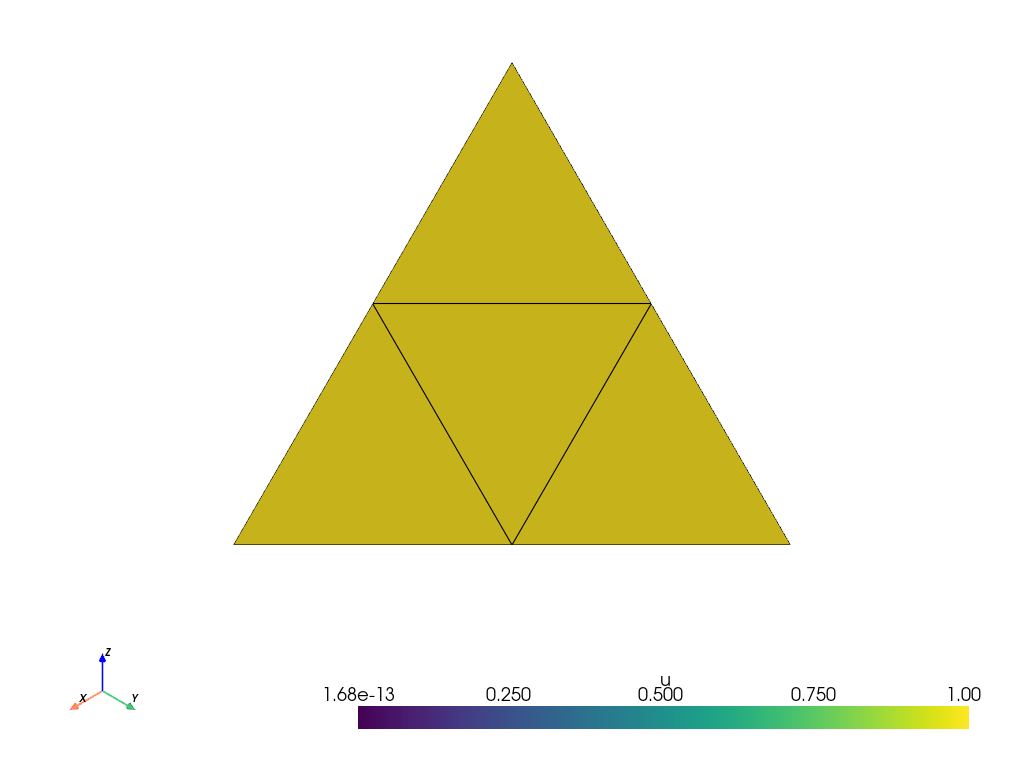

In [6]:
points = mesh.domains[0].vertices
cells = np.array([np.insert(element, 0, 4) for element in mesh.domains[0].elements[0].node_tags])
# cells1 = np.array([np.insert(element, 0, 4) for element in mesh.domains[0].elements[0].node_tags])
# cells2 = np.array([np.insert(element, 0, 4) for element in mesh.domains[1].elements[0].node_tags])
# cells = np.concatenate([cells1, cells2])
celltypes = [pv.CellType.TETRA] * cells.shape[0]

# pv.set_jupyter_backend("trame")
pv.set_jupyter_backend("static")

grid = pv.UnstructuredGrid()
grid = pv.UnstructuredGrid(cells, celltypes, points)
grid.point_data["u"] = sol
grid.plot(show_edges=True)

In [7]:
points = np.array(
  [
    [0, 0, 0],
    [0.1, 0.1, 0.1],
    [0.5, 0, 0],
    [0.5, 0, 0.5],
  ]
)
problem.project_into(points, sol)

[[1.    0.    0.    0.    0.875 0.    0.875 0.925 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.025 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.025 0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.    0.    0.025]]


array([1.337, 0.012, 0.075, 0.15 ])

In [8]:
points.sum(axis=1)

array([0. , 0.3, 0.5, 1. ])